In [140]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the data and defining plotting options

#### the data should be formatted as per the following table (indexing excluded). 
That is, tab-separated with column names as shown below and in the example input data file. 

Entries in 'name' and 'chromosome' may be strings.


In [157]:
df = pd.read_csv('example_data.tsv',delimiter='\t')
df

chrNames = df['chromosome'].unique()
print(chrNames)
numChrs = len(chrNames)

,name,chromosome,distance,H0,H1,H2,theta
0,H12,chr1,1,62864864,844714,13604,0.006841
1,H12,chr1,2,62850711,854466,8706,0.006842
2,H12,chr1,3,62840557,856190,7807,0.006843
3,H12,chr1,4,62831402,855898,7907,0.006843
4,H12,chr1,5,62821707,856675,7467,0.006843
...,...,...,...,...,...,...,...
19995,H36,chr2,996,60234782,832824,3753,0.006880
19996,H36,chr2,997,60224324,832716,3741,0.006880
19997,H36,chr2,998,60213978,832370,3841,0.006880
19998,H36,chr2,999,60203358,832565,3667,0.006880


In [158]:
## formatting choices for plots below ##

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(list(np.linspace(0,1,numChrs))))
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 13}
fontLabel = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

['chr1' 'chr2']


# formatting the data
Note that 'combine_chr_across_individuals()' is needed even for a sample of 1 to format the data correctly

In [178]:
# thisDF data frame is for a single chromosome only
def combine_chr_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['name'].unique())
    test = test.groupby(['distance'],as_index=False).sum()
    test['theta'] = test['theta']/numSamples
    test = test.to_numpy()
    return(test)


#### We will work with the data pooled across the 10 individuals in our example data set

In [159]:
pooledDataByChr = [
    combine_chr_across_individuals( df.loc[(df["chromosome"]==cName)] ) for cName in chrNames]

##### note that we can also do this for a single individual, in the folowing example, we only take the 'H30' individual's data 

In [183]:
# pooledDataByChr = [
#     combine_chr_across_individuals( df.loc[(df["chromosome"]==cName) & (df["name"]=='H30')]) for cName in chrNames]
# pooledDataByChr

# single-distance rho estimates for each chromosome

single_dist_obj_fun(): calculates the single-parameter rho/bp using het counts for a given distance d between sites and recombination rate r being tested by optimizer

find_max_like_single_dist(): initiates and runs optimization for  using NLOPT libarary 

rho_by_distance(): for a single chromosome, computes in parallel the rho/bp estimates for each distance d

NOTE: The boundaries and start point for the optimization can and should be changed to reflect parameters reasonable for the data set. 

In [125]:

def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)
    
def find_max_like_single_dist(testDist):
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.00001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testDist))
    res = opt.optimize(startPoint)
    return(res[0])

def rho_by_distance(chrArr):
    jobs = chrArr
    with Pool(cpu_count()) as p:
        single_dist_estimates = p.map(find_max_like_single_dist,jobs)
    return(single_dist_estimates)

#### for each chromosome, we obtain the rho/bp estimated across all distances

In [181]:
singleDistResByChr = [ rho_by_distance(x) for x in pooledDataByChr] 

Below, we plot the per-distance estimates for each chromosome (unique color)

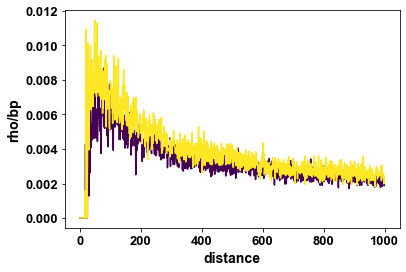

In [182]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(list(np.linspace(0,1,numChrs))))

for cres in singleDistResByChr:
    plt.plot(cres)
    plt.xlabel("distance",**fontLabel)
    plt.ylabel("rho/bp",**fontLabel)
plt.show()

# per-chromosome recombination rate estimates and the effect of minimum distance

### here, we are now co-estimating the rates of recombination (kappa), gene conversion (gamma) and mean tract length L

single_chr_obj_fun(): for a given chromosome and test-values for rec paraemters, calculates the objective function when compositing the likelihood over all distances 

calc_single_dist(): for a given chromosome, returns the likelihood of observing the data at a single distance under the full three-parameter recombination model   

In [162]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

#### HeRho_estimate_one_chromosome
This function takes the formatted data for a single chromosome and estimates the three recombination parameters using NLOPT.  

note: bounds and start-points for optimization should be chosen appropriately for the data set at hand 

In [163]:
def HeRho_estimate_one_chromosome(cArr):
  
    test = cArr

    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,test))
    res = opt.optimize(startPoints)
    return([x for x in res])

#### HeRho_get_chr_min_dist_effect():

Due to the noisiness of the data for small distances, we want to determine an appropriate minimum-distance cut-off for the data. This function takes a chromosome and list of minimum distances to test.   It returns the per-min-distance (kappa, gamma, L) estimates. 

Data from d<d_min is removed from the likelihood calculation in 'calc_chr_min_dist()'. 

In [164]:

def HeRho_get_chr_min_dist_effect(cArr,minDistList):
    jobs = minDistList
    jobs = [(cArr,x) for x in jobs]
    with Pool(cpu_count()) as p:
        estimateByMinDist=p.map(calc_chr_min_dist,jobs)
    estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))
    return(estimateByMinDist)

def calc_chr_min_dist(argv):
    cArr,minDist = argv
    test = cArr[ cArr[:,0]>=minDist]


    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,test))
    res = opt.optimize(startPoints)
    return([x for x in res])

### results for a single chromosome

Here, we estimate the  (kappa, gamma, L) for the first chromosome, using all distances avilable in the data set

In [165]:
HeRho_estimate_one_chromosome(pooledDataByChr[0])

[0.0009402588104037545, 0.0017312116469998203, 279.24989253616616]

### effect of min dist on single-chr estimates

Here, we test the effect of the choice of minimum distance on parameter estimates for each chromosome independently.

In [166]:
minDistVals = list(range(1,200,25))

In [167]:
resMinDistEffect = [HeRho_get_chr_min_dist_effect( x,minDistVals) for x in pooledDataByChr]

Plotting the effect

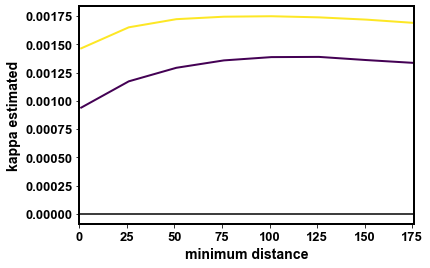

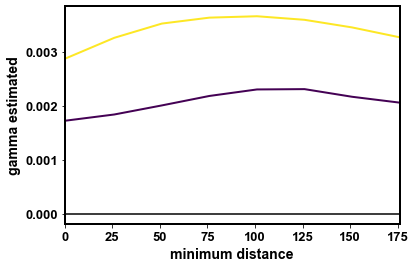

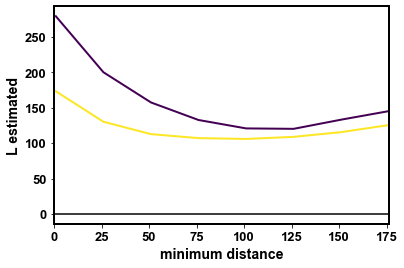

In [168]:
xvals = minDistVals

xmax = minDistVals[-1]

###
fig = plt.figure()
ax = fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
plt.xlabel("minimum distance",**fontLabel)
plt.ylabel("kappa estimated",**fontLabel)

for cRes in resMinDistEffect:
    plt.plot(xvals,cRes[0],linewidth=2)
plt.plot([0,xmax],[0,0],color = 'k')
plt.xlim([0,xmax])
plt.show()

###
fig = plt.figure()
ax = fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
plt.xlabel("minimum distance",**fontLabel)
plt.ylabel("gamma estimated",**fontLabel)

for cRes in resMinDistEffect:
    plt.plot(xvals,cRes[1],linewidth=2)
plt.plot([0,xmax],[0,0],color = 'k')
plt.xlim([0,xmax])
plt.show()

###
fig = plt.figure()
ax = fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
plt.xlabel("minimum distance",**fontLabel)
plt.ylabel("L estimated",**fontLabel)
for cRes in resMinDistEffect:
    plt.plot(xvals,cRes[2],linewidth=2)
plt.plot([0,xmax],[0,0],color ='k')
plt.xlim([0,xmax])
plt.show()

# Co-estimating rho across all chromosomes

Here, we want to co-Estimate a global tract length parameter L and chromsome-specific rates of crossover (kappa) and gene conversion (gamma).

across_chr_obj_fun(): sums the chromosome-specific likelihood using the current parameter values in the optimization

HeRho_estimate_genome(): runs the optimization to co-estimate all recombinaiton parameters for the genome provided

HeRho_format(): formats and prints the results of the genome-wide optimization procedure

In [169]:

def across_chr_obj_fun(x,dfArrList):
    numChrs = len(dfArrList)
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

def HeRho_estimate_genome(pooledChrs):
    
    numberChromosomes = len(pooledChrs)

    lowerBounds = [0.0001 for x in range(numberChromosomes)]+ [0.0001 for x in range(numberChromosomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromosomes)]+[0.1 for x in range(numberChromosomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromosomes)]+[0.001 for x in range(numberChromosomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromosomes+numberChromosomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,pooledChrs))

    res = opt.optimize(startPoints)
    return(res)


def HeRho_format(coEstimates,chrNames):
    numChrs = len(chrNames)
    kappas = coEstimates[0:numChrs]
    gammas = coEstimates[numChrs:numChrs*2]
    L = coEstimates[-1]
    print("Global estimate of tract length L = {}".format(L))
    print("chr\tkappa\tgamma")
    for name, kappa, gamma in list(zip(chrNames, kappas, gammas)):
        print("{}\t{}\t{}".format(name, kappa, gamma))
    
    

#### Minimum distance choice

above, we looked at how the choice of minimum distance affects the recombination estimates independently for each chromosome.  Excepting the poor data at short distances, the estimates should be 'stable' over a range of minimum distances as long as there is sufficient data remaining. 

Based on the observations above, we decide to use a minimum distance of 100 bp in the final analysis. As a first step, we remove those sites with d < 100 from our data set:

In [170]:
minimumDistanceChosen = 100
pooledDataByChrWithMinDist = [ x[ x[:,0] >= minimumDistanceChosen] for x in pooledDataByChr]

With a minimum distance chosen, we can co-estimate the genome-wide recombination rate parameters

In [171]:
rhoCoEstimates = HeRho_estimate_genome(pooledDataByChrWithMinDist)

Finally, we format and print the results 

In [172]:
HeRho_format(rhoCoEstimates,chrNames)

Global estimate of tract length L = 112.64071181609407
chr	kappa	gamma
chr1	0.0014130773845440032	0.002389442767085215
chr2	0.0017174430276408752	0.003543906102984039
